In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
import os
import random
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud







In [2]:

# Descargar e instalar el modelo de spaCy si no está presente
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print('Descargando el modelo en_core_web_sm de spaCy...')
    # La siguiente línea es para ejecutar en un entorno de notebook/terminal
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')



In [3]:


# #### 2. Carga y Exploración de Datos (con muestra aleatoria)
# Leemos una muestra aleatoria para acelerar el prototipado sin sesgos.

try:
    # --- PARÁMETROS PARA EL MUESTREO ---
    total_filas = 1600000
    filas_a_leer = 1600000
    probabilidad = filas_a_leer / total_filas

    # --- LÍNEA MODIFICADA ---
    # Usamos skiprows con una función lambda para muestreo aleatorio
    df = pd.read_csv('data/training.1600000.processed.noemoticon.csv',
        encoding='latin-1',
        header=None,
        # Omitir una fila si un número aleatorio es mayor que nuestra probabilidad
        skiprows=lambda i: i > 0 and random.random() > probabilidad
    )
    print(f'Dataset cargado exitosamente (muestra aleatoria de ~{filas_a_leer} filas).')
    print(df.head())

    # Asignar nombres a las columnas
    df.columns = ['Sentiment', 'id', 'date', 'query', 'user', 'Text']
    
    # Eliminar columnas innecesarias
    cols_to_drop = ['id', 'date', 'query']
    df = df.drop(columns=cols_to_drop)
    
    print('\nPrimeras 10 filas de la muestra aleatoria:')
    print(df.head(10))
    
    print(f'\nDimensiones de la muestra: {df.shape}')

except FileNotFoundError:
    print('Error: El archivo no fue encontrado.')
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Dataset cargado exitosamente (muestra aleatoria de ~1600000 filas).
   0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  

Primeras 10 filas de la muestra aleatoria:
   Sentiment             user  \
0          0  _TheSpecialOne_   
1          0    scotthamilton

In [4]:
# #### 3. Mapeo de Sentimientos (Simplificado)
# Mapeamos los valores numéricos del sentimiento (0 y 4) a etiquetas de texto.
if 'df' in locals():
    # El valor 0 es Negativo y 4 es Positivo.
    df['Sentiment'] = df['Sentiment'].map({0: 'Negative', 4: 'Positive'})
    
    # Creamos la copia después del mapeo
    df_copy = df.copy()

    print('Distribución de sentimientos tras el mapeo:')
    print(df['Sentiment'].value_counts())

    

Distribución de sentimientos tras el mapeo:
Sentiment
Negative    800000
Positive    800000
Name: count, dtype: int64


Generando nubes de palabras... (esto puede tardar un momento)


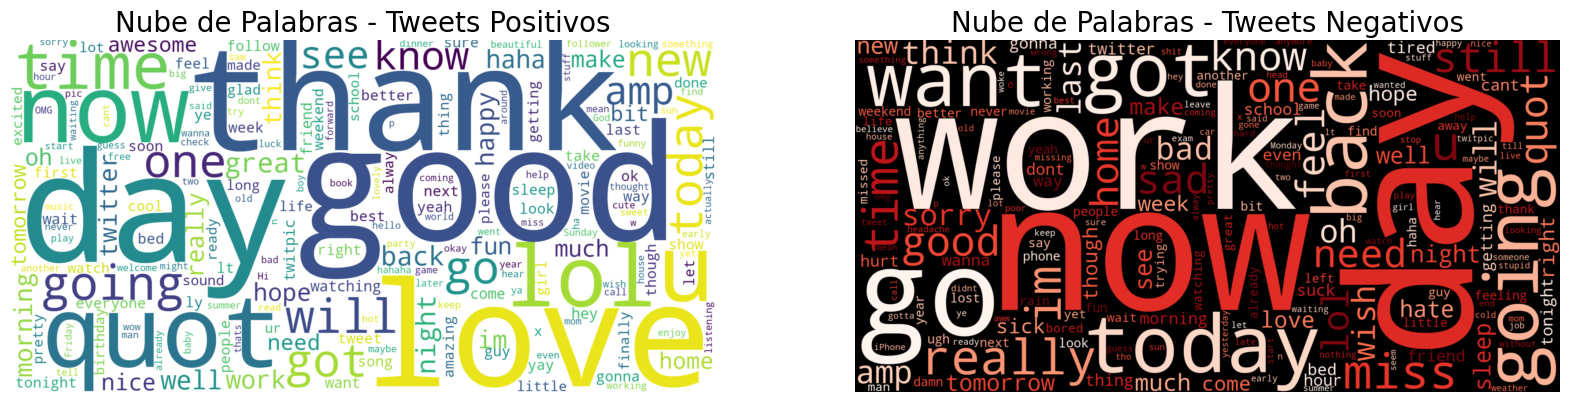

In [ ]:
# --- CÓDIGO PARA INTEGRAR EN TU NOTEBOOK ---


# Usaremos df_copy que tiene el dataset completo antes de la división
# y las etiquetas de texto 'Positive' y 'Negative'.

print("Generando nubes de palabras... no será util, pero queda lindo)")

# 1. Separamos los tweets positivos y negativos
# Adaptado para usar tus nombres de columna ('Sentiment', 'Text') y valores ('Positive', 'Negative')
positive_tweets = df_copy[df_copy['Sentiment'] == 'Positive']['Text'].str.cat(sep=' ')
negative_tweets = df_copy[df_copy['Sentiment'] == 'Negative']['Text'].str.cat(sep=' ')

# 2. Creamos las nubes de palabras
wordcloud_pos = WordCloud(width=1600, height=800, background_color='white', collocations=False).generate(positive_tweets)
wordcloud_neg = WordCloud(width=1600, height=800, background_color='black', colormap='Reds', collocations=False).generate(negative_tweets)

# 3. Mostramos los gráficos
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Nube de Palabras - Tweets Positivos', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Nube de Palabras - Tweets Negativos', fontsize=20)
plt.axis('off')

plt.show()

In [6]:

# #### 4. Preprocesamiento de Texto
# Función de limpieza robusta que maneja posibles valores no textuales, convierte a minúsculas, elimina caracteres no deseados, lematiza y quita *stop words*.
def limpieza(texto):
    """Realiza una limpieza completa del texto, incluyendo manejo de casos nulos."""
    if not isinstance(texto, str):
        return ""
    
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    
    # Procesar con spacy solo si el texto no está vacío
    if not texto:
        return ""
        
    doc = nlp(texto)
    texto_limpio = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    
    return texto_limpio

# ### Preparación de Datos para Modelado
if 'df_copy' in locals():
    X = df_copy['Text'].apply(limpieza)
    
    # Mapeamos 'Negative' a -1 y 'Positive' a 1
    y = df_copy['Sentiment'].map({'Negative': -1, 'Positive': 1})

    # Eliminar filas donde 'y' podría ser NaN si hubo valores de sentimiento inesperados
    # y asegurarse de que los índices coincidan
    valid_indices = y.notna()
    X = X[valid_indices]
    y = y[valid_indices]

    # Dividir los datos, estratificando por 'y' para mantener la proporción de clases
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print(f"\n- Data para modelado preparada -")
    print(f"Tamaño de X_train: {X_train.shape[0]}")
    print(f"Tamaño de X_test: {X_test.shape[0]}")
    print(f"\nDistribución en y_train:\n{y_train.value_counts()}")


- Data para modelado preparada -
Tamaño de X_train: 1120000
Tamaño de X_test: 480000

Distribución en y_train:
Sentiment
 1    560000
-1    560000
Name: count, dtype: int64


In [7]:

# ### Modelo 3: TF-IDF + Regresión Logística
# Este método pondera la importancia de las palabras según su frecuencia en el documento y en todo el corpus (TF-IDF). Se combina con una Regresión Logística, un modelo lineal robusto para clasificación.
if 'X_train' in locals():
    # Vectorización con TF-IDF
    vectorizer_tfidf = TfidfVectorizer()
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
    X_test_tfidf = vectorizer_tfidf.transform(X_test)

    # Entrenamiento del modelo de Regresión Logística
    # Se aumenta max_iter para asegurar la convergencia
    model_lr = LogisticRegression(random_state=42, max_iter=1000)
    model_lr.fit(X_train_tfidf, y_train)

    # Predicciones
    y_train_pred_lr = model_lr.predict(X_train_tfidf)
    y_test_pred_lr = model_lr.predict(X_test_tfidf)

    # Reporte de Clasificación
    print("\n--- Reporte de Clasificación: TF-IDF + Regresión Logística (Train) ---")
    print(classification_report(y_train, y_train_pred_lr))
    print("\n--- Reporte de Clasificación: TF-IDF + Regresión Logística (Test) ---")
    print(classification_report(y_test, y_test_pred_lr))


--- Reporte de Clasificación: TF-IDF + Regresión Logística (Train) ---
              precision    recall  f1-score   support

          -1       0.82      0.78      0.80    560000
           1       0.79      0.83      0.81    560000

    accuracy                           0.81   1120000
   macro avg       0.81      0.81      0.80   1120000
weighted avg       0.81      0.81      0.80   1120000


--- Reporte de Clasificación: TF-IDF + Regresión Logística (Test) ---
              precision    recall  f1-score   support

          -1       0.79      0.76      0.77    240000
           1       0.76      0.79      0.78    240000

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



In [8]:
# 1. Vectorización Optimizada (como ya la tenías)
print("Paso 1: Realizando vectorización TF-IDF optimizada...")
vectorizer_tfidf_opt = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=20000,
    min_df=5,
    max_df=0.7
)
X_train_tfidf_opt = vectorizer_tfidf_opt.fit_transform(X_train)
X_test_tfidf_opt = vectorizer_tfidf_opt.transform(X_test)
print("Vectorización completada.")

# 2. Búsqueda de Hiperparámetros con GridSearchCV
print("\nPaso 2: Iniciando búsqueda del mejor hiperparámetro 'C' con GridSearchCV...")

# Define el modelo base
model_lr = LogisticRegression(random_state=42, max_iter=1000)

# Define la grilla de parámetros a probar para 'C'
# Probaremos valores más pequeños que 1 para aumentar la regularización y combatir el overfitting
param_grid = {
    'C': [0.1, 0.5, 1] 
}

# Configura la búsqueda con validación cruzada (cv=3 para que sea más rápido)
grid_search = GridSearchCV(
    estimator=model_lr,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro', # Métrica para optimizar
    verbose=1,
    n_jobs=-1 # Usa todos los procesadores
)

# Ejecuta el entrenamiento
grid_search.fit(X_train_tfidf_opt, y_train)
print("Búsqueda de hiperparámetros completada.")
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

# 3. Obtener y Evaluar el Mejor Modelo
print("\nPaso 3: Evaluando el mejor modelo encontrado...")

# 'best_estimator_' es el modelo de Regresión Logística ya entrenado con el mejor 'C'
best_model_lr = grid_search.best_estimator_

# Evaluar el rendimiento en Train
print("\n--- Reporte de Clasificación (Train) ---")
y_train_pred = best_model_lr.predict(X_train_tfidf_opt)
print(classification_report(y_train, y_train_pred))

# Evaluar el rendimiento en Test
print("\n--- Reporte de Clasificación (Test) ---")
y_test_pred = best_model_lr.predict(X_test_tfidf_opt)
print(classification_report(y_test, y_test_pred))

# 4. Guardar el Mejor Modelo y el Vectorizer
print("\nPaso 4: Guardando el modelo y el vectorizer optimizados...")

output_dir = 'model_robust'
os.makedirs(output_dir, exist_ok=True)

# Guardamos el vectorizer que usamos para entrenar
joblib.dump(vectorizer_tfidf_opt, os.path.join(output_dir, 'schimizzi_vectorizer_final.joblib'))

# Guardamos el MEJOR modelo encontrado por GridSearchCV
joblib.dump(best_model_lr, os.path.join(output_dir, 'schimizzi_modelo_final.joblib'))

print(f"\n✅ ¡Éxito! Modelo y vectorizador finales guardados en la carpeta '{output_dir}'.")

Paso 1: Realizando vectorización TF-IDF optimizada...
Vectorización completada.

Paso 2: Iniciando búsqueda del mejor hiperparámetro 'C' con GridSearchCV...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Búsqueda de hiperparámetros completada.
Mejores parámetros encontrados: {'C': 0.5}

Paso 3: Evaluando el mejor modelo encontrado...

--- Reporte de Clasificación (Train) ---
              precision    recall  f1-score   support

          -1       0.80      0.76      0.78    560000
           1       0.77      0.81      0.79    560000

    accuracy                           0.78   1120000
   macro avg       0.78      0.78      0.78   1120000
weighted avg       0.78      0.78      0.78   1120000


--- Reporte de Clasificación (Test) ---
              precision    recall  f1-score   support

          -1       0.79      0.75      0.77    240000
           1       0.76      0.80      0.78    240000

    accuracy                           0.78    480000
   macro avg       0.78 

Guardar los archivos

Cargar los archivos para usarlos

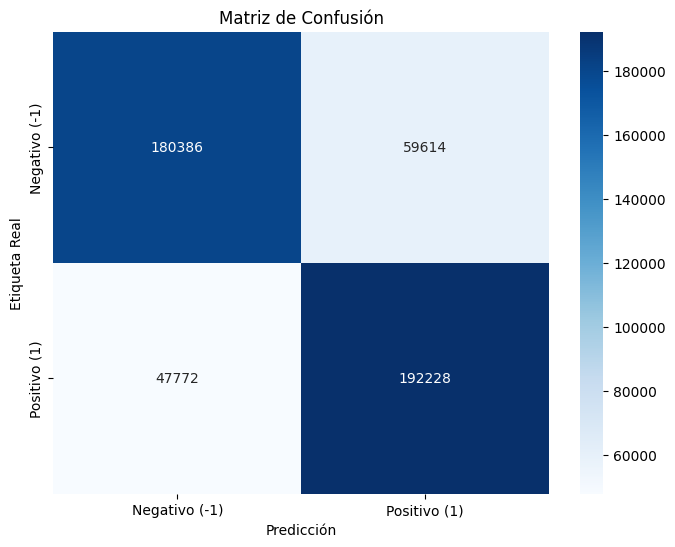

In [9]:

# --- LÍNEA CORREGIDA ---
# Usa 'best_model_lr' (el modelo entrenado) en lugar de 'model_lr' (la plantilla sin entrenar)
y_pred = best_model_lr.predict(X_test_tfidf_opt)

# El resto del código permanece igual
cm = confusion_matrix(y_test, y_pred)

# Visualízala
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo (-1)', 'Positivo (1)'],
            yticklabels=['Negativo (-1)', 'Positivo (1)'])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

In [10]:

# 1. Cargar los objetos guardados
vectorizer_cargado = joblib.load('model/schimizzi_vectorizer.joblib')
modelo_cargado = joblib.load('model/schimizzi_modelo_s.joblib')

# 2. Nuevos datos para predecir
nuevos_datos = [
    "I love this product, it's the best thing I've ever bought!", # Positivo
    "This is a terrible experience, I'm so disappointed.",     # Negativo
]

# 3. Usar el VECTORIZER CARGADO para transformar el texto
nuevos_datos_transformados = vectorizer_cargado.transform(nuevos_datos)

# 4. Usar el MODELO CARGADO para hacer la predicción
predicciones = modelo_cargado.predict(nuevos_datos_transformados)

# 5. Interpretar el resultado (-1: Negativo, 1: Positivo)
for texto, sentimiento in zip(nuevos_datos, predicciones):
    resultado = "Positivo" if sentimiento == 1 else "Negativo"
    print(f"Texto: '{texto}' -> Sentimiento Predicho: {resultado}")

FileNotFoundError: [Errno 2] No such file or directory: 'model/schimizzi_vectorizer.joblib'

In [ ]:


# 1. Cargar los objetos guardados
try:
    vectorizer_cargado = joblib.load('model/schimizzi_vectorizer.joblib')
    modelo_cargado = joblib.load('model/schimizzi_modelo_s.joblib')
    print("Vectorizer y modelo cargados correctamente.")

    # 2. Leer los datos desde el archivo CSV (corregido)
    predict_csv = 'data/testdata.manual.2009.06.14.csv'
    # Cargar sin encabezado y asignar nombres a las columnas
    df_nuevos = pd.read_csv(predict_csv, header=None, encoding='latin-1')
    df_nuevos.columns = ['Sentiment', 'id', 'date', 'query', 'user', 'Text']

    # --- ¡PUNTO CLAVE CORREGIDO! ---
    # Extraer la columna de texto correcta ('Text')
    nuevos_datos = df_nuevos['Text'].tolist()
    
    print(f"\\nFrases cargadas desde la columna 'Text' del archivo '{predict_csv}':")
    for frase in nuevos_datos[:5]: # Mostramos solo las primeras 5 para brevedad
        print(f"- {frase}")

    # (El resto del código para transformar y predecir permanece igual)
    # ...

except FileNotFoundError:
    print("\\nError: No se encontraron los archivos del modelo o el archivo CSV.")
except KeyError:
    print(f"\\nError: La columna 'Text' no se encontró en el archivo CSV.")
    print("Por favor, verifica el nombre de la columna en tu archivo.")
except Exception as e:
    print(f"\\nOcurrió un error inesperado: {e}")

Vectorizer y modelo cargados correctamente.
\nFrases cargadas desde la columna 'Text' del archivo 'data/testdata.manual.2009.06.14.csv':
- @stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.
- Reading my kindle2...  Love it... Lee childs is good read.
- Ok, first assesment of the #kindle2 ...it fucking rocks!!!
- @kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
- @mikefish  Fair enough. But i have the Kindle2 and I think it's perfect  :)


In [ ]:


# Opciones de visualización
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 200)

print("--- Muestra de Predicciones del Conjunto de Prueba ---")

# Seleccionar 10 muestras del set de prueba
indices_muestra = X_test.head(10).index
textos_originales = df_copy.loc[indices_muestra]['Text']
muestras_transformadas = vectorizer_tfidf_opt.transform(X_test.head(10))

# --- LÍNEA CORREGIDA ---
# Usar 'best_model_lr' (el modelo entrenado) en lugar de 'model_lr'
predicciones_muestra = best_model_lr.predict(muestras_transformadas)

# El resto del código no cambia
etiquetas_reales = y_test.head(10).values
mapa_sentimiento = {-1: "Negativo", 1: "Positivo"}

for i in range(10):
    texto = textos_originales.iloc[i]
    prediccion = mapa_sentimiento[predicciones_muestra[i]]
    etiqueta_real = mapa_sentimiento[etiquetas_reales[i]]
    print(f"\nTweet: {texto}")
    print(f"  ➡️ Predicción: {prediccion} (Etiqueta Real: {etiqueta_real})")

--- Muestra de Predicciones del Conjunto de Prueba ---

Tweet: Is it wrong to masturbate while he drives? 
  ➡️ Predicción: Negativo (Etiqueta Real: Positivo)

Tweet: http://twitpic.com/6aosp - onions garlic spinach artichokes 
  ➡️ Predicción: Positivo (Etiqueta Real: Positivo)

Tweet: @elissaalva HEEEEYYYYY GIIIRRRRRRLLLLL!!!!!!! I hope all is well with you 
  ➡️ Predicción: Positivo (Etiqueta Real: Positivo)

Tweet: In bed alone again   I want to snuggle!!!!
  ➡️ Predicción: Negativo (Etiqueta Real: Negativo)

Tweet: @MissLoisme I am happy he is still smiling, it will be a sad day when Johnny Castle is no more 
  ➡️ Predicción: Positivo (Etiqueta Real: Negativo)

Tweet: http://twitpic.com/7r0ik - i miss tory! 
  ➡️ Predicción: Negativo (Etiqueta Real: Negativo)

Tweet: @walterelly guess not  but it was fun while it lasted.
  ➡️ Predicción: Positivo (Etiqueta Real: Negativo)

Tweet: has been having &quot;stomach problems&quot; for waaay too long 
  ➡️ Predicción: Positivo (Etiqueta R

In [ ]:


print("--- Proceso de Predicción para el Nuevo Muestreo ---")

try:
    # 1. Cargar el vectorizer y el modelo guardados
    vectorizer_cargado = joblib.load('model/schimizzi_vectorizer_final.joblib')
    modelo_cargado = joblib.load('model/schimizzi_modelo_final.joblib')
    print("Vectorizer y modelo cargados correctamente.")

    # 2. Cargar el nuevo archivo CSV que quieres predecir
    ruta_archivo_nuevo = 'data/testdata.manual.2009.06.14.csv'
    df_nuevo_muestreo = pd.read_csv(ruta_archivo_nuevo, header=None, encoding='latin-1')
    df_nuevo_muestreo.columns = ['Sentiment_Real', 'id', 'date', 'query', 'user', 'Text']
    print(f"Archivo '{ruta_archivo_nuevo}' cargado.")

    # 3. Limpiar el texto del nuevo archivo
    print("Limpiando texto...")
    textos_nuevos_limpios = df_nuevo_muestreo['Text'].apply(limpieza)

    # 4. Usar los objetos CARGADOS para predecir
    print("Realizando predicciones...")
    
    # --- LÍNEAS CORREGIDAS ---
    # a. Transformar con el VECTORIZER CARGADO
    textos_nuevos_transformados = vectorizer_cargado.transform(textos_nuevos_limpios)
    # b. Predecir con el MODELO CARGADO
    predicciones_nuevas = modelo_cargado.predict(textos_nuevos_transformados)

    # 5. Crear el DataFrame final con los resultados
    print("Generando el reporte final...")
    df_final = df_nuevo_muestreo[['user', 'date', 'Text']].copy()
    mapa_sentimiento = {-1: "Negativo", 1: "Positivo"}
    df_final['Sentimiento_Predicho'] = pd.Series(predicciones_nuevas).map(mapa_sentimiento)

    # 6. Guardar los resultados
    nombre_archivo_excel = 'predict/predicciones_muestreo.xlsx'
    df_final.to_excel(nombre_archivo_excel, index=False, engine='openpyxl')

    print(f"\n✅ ¡Éxito! Se guardaron las predicciones en '{nombre_archivo_excel}'.")
    print("\nPrimeras filas del archivo de predicciones:")
    print(df_final.head(20))

except FileNotFoundError:
    print(f"\nError: No se encontró el archivo en la ruta '{ruta_archivo_nuevo}' o los archivos del modelo.")
except Exception as e:
    print(f"\nOcurrió un error inesperado: {e}")

--- Proceso de Predicción para el Nuevo Muestreo ---
Vectorizer y modelo cargados correctamente.
Archivo 'data/testdata.manual.2009.06.14.csv' cargado.
Limpiando texto...
Realizando predicciones...
Generando el reporte final...

✅ ¡Éxito! Se guardaron las predicciones en 'predict/predicciones_muestreo.xlsx'.

Primeras filas del archivo de predicciones:
              user                          date                                                                                                 Text Sentimiento_Predicho
0           tpryan  Mon May 11 03:17:40 UTC 2009  @stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in...             Positivo
1           vcu451  Mon May 11 03:18:03 UTC 2009                                           Reading my kindle2...  Love it... Lee childs is good read.             Positivo
2           chadfu  Mon May 11 03:18:54 UTC 2009                                           Ok, first assesment of the #kindle2 ...it